In [1]:
import numpy as np
import cosmology
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo, z_at_value
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
import coop_post_processing as cpp
import coop_setup_funcs as csf
import healpy as hp
from astropy import wcs
import os

In [2]:
def calc_offsets(rot_angle, rot_angle_standard):
    diffs = []
    for i in range(len(rot_angle)):
        a = rot_angle[i] - rot_angle_standard[i]
        a = (a + np.pi) % (2*np.pi) - np.pi
        diffs.append(abs(a))
    diffs = np.asarray(diffs)
    diffs[diffs>(np.pi/2.)]-=np.pi
    diffs = (np.abs(diffs)*u.rad).to(u.deg)
    return diffs


def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

# Maglim tests with Buzzard

# Testing: Maglim vs RedMaGic
Which is better when using the photo-zs as is, 200 Mpc slices, and clusters within 50 Mpc of the slice center? Compare to the Buzzard Maglim catalog with true redshifts.  

In [3]:
nd = hp.read_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/maglim_truez/odmap_100_1432_1632Mpc.fits")

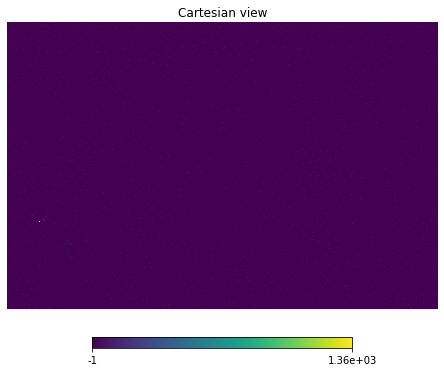

In [4]:
odmap = hp.cartview(nd, lonra=[10,40], latra=[-40,-20], return_projected_map=True)

In [5]:
odmap[odmap==0]=-1

In [9]:
# maglim_truepath = ?

In [10]:
# lonmin=10
# lonmax=40
# latmin=-40
# latmax=-20

# binmin, binmax = 1432, 1632
# angle, ra, dec = cpp.peakinfo_radec(maglim_truepath + "lambdagt20_{:d}_{:d}Mpc_20pt0_orient_100pct_maglim_truez_pks.fits".format(binmin, binmax))
# condition = (ra>lonmin) & (ra < lonmax) & (dec>latmin) & (dec<latmax)
# w = wcs.WCS(naxis=2)
# height = float(odmap_s.shape[0])
# length = float(odmap_s.shape[1])
# cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
# cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
# w.wcs.crpix = length/2., height/2.
# print(w.wcs.crpix)
# w.wcs.crval = [crvalX,crvalY]
# print(w.wcs.crval)
# w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
# print(w.wcs.cdelt)
# w.wcs.ctype = ["RA", "DEC"]
# # Make the figure
# plt.figure(figsize=[12,8])
# Xpix,Ypix = w.all_world2pix(ra[condition],dec[condition],0)
# nrows = 1
# ax1 = plt.subplot(nrows, 1, 1, projection=w)
# ax1.imshow(odmap_s[::-1])
# ax1.set_xticks([])
# ax1.set_xticklabels([])
# cm = plt.get_cmap("coolwarm")
# U_arr, V_arr = get_vector_components(angle[condition])
# ax1.scatter(Xpix,Ypix,color='w')
# # only plot some
# ax1.quiver(Xpix, Ypix, U_arr, -V_arr, width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
# ax1.quiver(Xpix, Ypix, -U_arr, V_arr, width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
# plt.title(r"Smoothed $\delta$ map")
# plt.xlabel("RA")
# plt.ylabel("Dec")


In [11]:
maglim_path = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/orient_by_maglim_100/"
redmagic_path = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/orient_by_redmagic_100/"
maglim_truepath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/orient_by_maglim_truez_100/"

In [12]:
dlist = [[1232,1432], [1332,1532], [1432,1632],[1532,1732],[1632,1832],[1732,1932], [1832,2032], [1932,2132], [2032,2232]]


# average differences
ideal_angles      = []
maglim_angles     = []
redmagic_angles   = []
ra_all  = []
dec_all = []
for dbin in dlist:
    binmin, binmax = dbin[0], dbin[1]
    angle_maglim, ra_maglim, dec_maglim = cpp.peakinfo_radec(maglim_path + "lambdagt20_{:d}_{:d}Mpc_20pt0_orient_100pct_maglim_pks.fits".format(binmin, binmax))
    maglim_angles.extend(angle_maglim)
    angle_maglim_true, ra_maglim_true, dec_maglim_true = cpp.peakinfo_radec(maglim_truepath + "lambdagt20_{:d}_{:d}Mpc_20pt0_orient_100pct_maglim_truez_pks.fits".format(binmin, binmax))
    ideal_angles.extend(angle_maglim_true)
    angle_rm, ra_rm, dec_rm = cpp.peakinfo_radec(redmagic_path + "lambdagt20_{:d}_{:d}Mpc_20pt0_orient_100pct_redmagic_pks.fits".format(binmin, binmax))
    redmagic_angles.extend(angle_rm)
    ra_all.extend(ra_maglim)
    dec_all.extend(dec_maglim)
ideal_angles = np.asarray(ideal_angles)
maglim_angles =  np.asarray(maglim_angles)
redmagic_angles   = np.asarray(redmagic_angles)
ra_all  = np.asarray(ra_all)
dec_all = np.asarray(dec_all)

(array([155., 157., 193., 157., 167., 169., 153., 164., 170., 130.]),
 array([ 0.14632884,  9.12725623, 18.10818361, 27.089111  , 36.07003839,
        45.05096577, 54.03189316, 63.01282055, 71.99374793, 80.97467532,
        89.95560271]),
 <BarContainer object of 10 artists>)

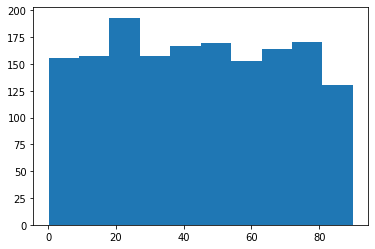

In [13]:
# demonstrate that the calc_offset function results in a uniform distribution from 0 to 90 if the angles are uncorrelated
rand_angles = np.random.uniform(size=len(ideal_angles))
rand_angles = rand_angles*(max(ideal_angles)-min(ideal_angles))+min(ideal_angles)
rand = calc_offsets(rand_angles, ideal_angles)
plt.hist(rand.value)

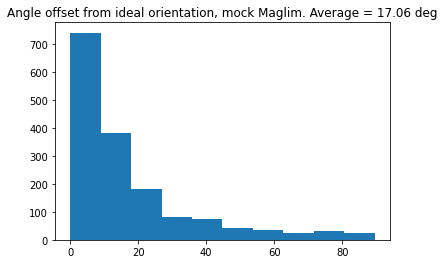

Text(0.5, 1.0, 'Angle offset from ideal orientation, mock redMaGiC. Average = 20.21 deg')

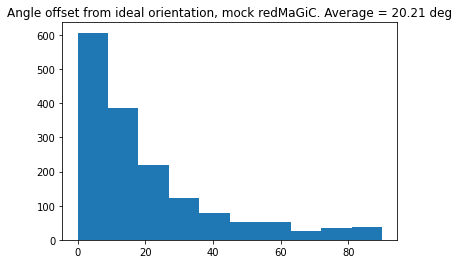

In [14]:
# compare
maglim     = calc_offsets(maglim_angles, ideal_angles)
redmagic   = calc_offsets(redmagic_angles, ideal_angles)
plt.hist(maglim.value)
plt.title("Angle offset from ideal orientation, mock Maglim. Average = {:.2f}".format(np.mean(maglim)))
plt.show()
plt.hist(redmagic.value)
plt.title("Angle offset from ideal orientation, mock redMaGiC. Average = {:.2f}".format(np.mean(redmagic)))

In [19]:
len(maglim[maglim.value<10])/len(maglim)

0.5003095975232198

In [20]:
len(redmagic[redmagic.value<10])/len(redmagic)

0.40743034055727556

odmap_mock_maglim_photoz_nowgt_distMpc1932_2132_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc1832_2032_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc1732_1932_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc1432_1632_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc2032_2232_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc2132_2332_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc1632_1832_0arcmin.fits
odmap_mock_maglim_photoz_nowgt_distMpc1532_1732_0arcmin.fits


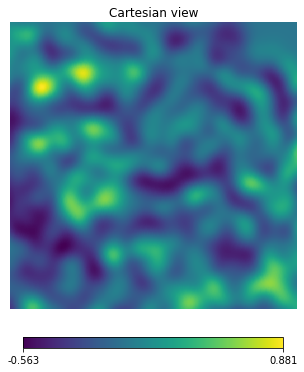

In [24]:
path = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/photoz_unweighted/"
min_dist = 1432
max_dist = 1632
for f in os.listdir(path):
    print(f)
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        unwgt_smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.3))
        hp.cartview(unwgt_smthmap, lonra=[0,10], latra=[-5,5])


odmap_mock_maglim_photoz_mult_distMpc1432_1632_0arcmin.fits


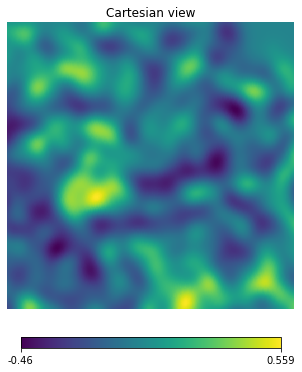

In [25]:
path = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/photoz_weighted/"
min_dist = 1432
max_dist = 1632
for f in os.listdir(path):
    if str(min_dist) in f and str(max_dist) in f:
        print(f)
        odmap = hp.read_map(path+f)
        wgt_smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.3))
        hp.cartview(wgt_smthmap, lonra=[0,10], latra=[-5,5])

odmap_mock_maglim_truez_distMpc1432_1632_0arcmin.fits


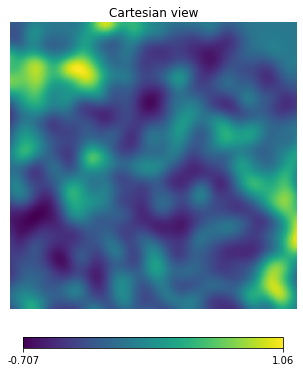

In [26]:
path = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/truez/"
min_dist = 1432
max_dist = 1632
for f in os.listdir(path):
    if str(min_dist) in f and str(max_dist) in f:
        print(f)
        odmap = hp.read_map(path+f)
        true_smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.3))
        hp.cartview(true_smthmap, lonra=[0,10], latra=[-5,5])

In [27]:
mask = hp.read_map("/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits")

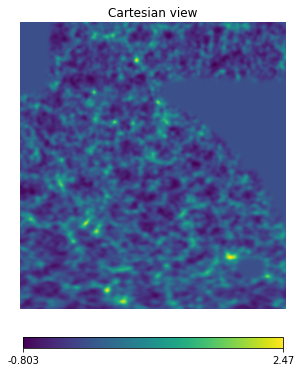

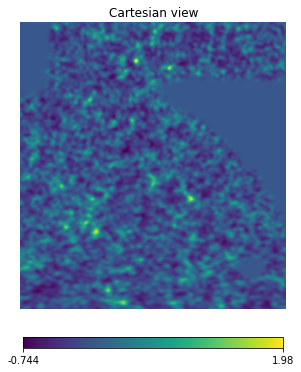

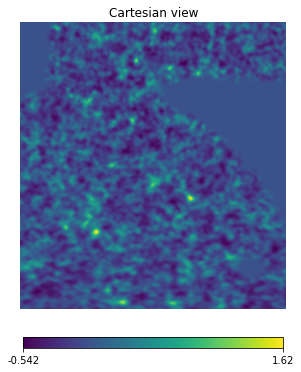

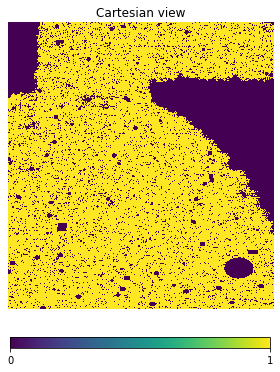

In [103]:
latrange = [-50,4]
lonrange = [0,50]
tru   = hp.cartview(true_smthmap, lonra=lonrange, latra=latrange, return_projected_map=True)
unwgt = hp.cartview(unwgt_smthmap, lonra=lonrange, latra=latrange, return_projected_map=True)
wgt   = hp.cartview(wgt_smthmap, lonra=lonrange, latra=latrange, return_projected_map=True)
mask_cart  = hp.cartview(mask, lonra=lonrange, latra=latrange, return_projected_map=True)

Text(0.5, 1.0, 'photo-z, weighted')

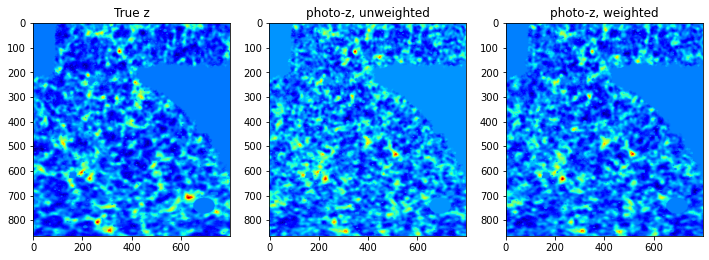

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])
ax[0].imshow((tru*mask_cart)[::-1], cmap='jet')
ax[1].imshow((unwgt*mask_cart)[::-1], cmap='jet')
ax[2].imshow((wgt*mask_cart)[::-1], cmap='jet')
ax[0].set_title("True z")
ax[1].set_title("photo-z, unweighted")
ax[2].set_title("photo-z, weighted")

# Check orientations

In [71]:
#mode = 'ideal'
mode = 'unweighted_photoz'
# mode = 'weighted_photoz'
pkspath = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/pks/"
if mode=='ideal':
    mapspath = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/truez/"
elif mode=='unweighted_photoz':
    mapspath = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/photoz_unweighted/"
elif mode=='weighted_photoz':
    mapspath = "/mnt/raid-cita/mlokken/buzzard/testing_photoz/photoz_weighted/"

[400. 432.]
[ 25. -23.]
[-0.0625  0.0625]


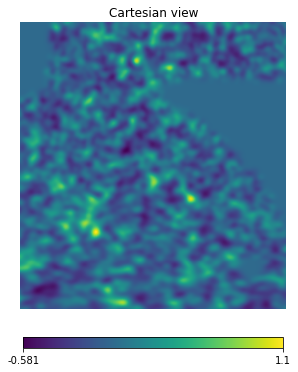

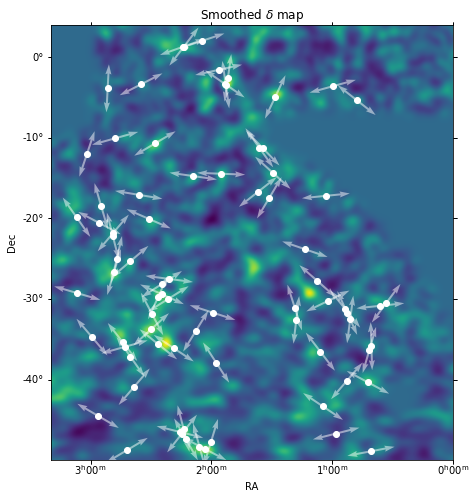

In [72]:
dlist = [[1432,1632]]
lonmin=lonrange[0]
lonmax=lonrange[1]
latmin=latrange[0]
latmax=latrange[1]
for dbin in dlist:
    binmin, binmax = dbin[0], dbin[1]
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_{:s}_distMpc_{:d}_{:d}.fits".format(mode, binmin, binmax))
#     if mode=='ideal':
#         odmap = hp.read_map(mapspath+"odmap_1e+12_1e+16_distMpc{:d}_{:d}.fits".format(binmin,binmax))
#     elif mode=='unweighted_photoz':
#         odmap = hp.read_map(mapspath+"odmap_mock_maglim_photoz_nowgt_distMpc{:d}_{:d}_0arcmin.fits".format(binmin,binmax))
#     elif mode=='weighted_photoz':
#         odmap = hp.read_map(mapspath+"odmap_mock_maglim_photoz_wgt_distMpc{:d}_{:d}_0arcmin.fits".format(binmin,binmax))
#     print("smoothing map.")
#     smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
    od_smthmap_flat = hp.cartview(smthmap, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)
    condition = (ra>lonmin) & (ra < lonmax) & (dec>latmin) & (dec<latmax)
    w = wcs.WCS(naxis=2)
    height = float(od_smthmap_flat.shape[0])
    length = float(od_smthmap_flat.shape[1])
    cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
    cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
    w.wcs.crpix = length/2., height/2.
    print(w.wcs.crpix)
    w.wcs.crval = [crvalX,crvalY]
    print(w.wcs.crval)
    w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
    print(w.wcs.cdelt)
    w.wcs.ctype = ["RA", "DEC"]
    # Make the figure
    plt.figure(figsize=[12,8])
    Xpix,Ypix = w.all_world2pix(ra[condition],dec[condition],0)
    nrows = 1
    ax1 = plt.subplot(nrows, 1, 1, projection=w)
    ax1.imshow(od_smthmap_flat)
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    cm = plt.get_cmap("coolwarm")
    U_arr, V_arr = get_vector_components(angle[condition])
    ax1.scatter(Xpix,Ypix,color='w')
    # only plot some
    ax1.quiver(Xpix, Ypix, U_arr, -V_arr, width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
    ax1.quiver(Xpix, Ypix, -U_arr, V_arr, width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
    plt.title(r"Smoothed $\delta$ map")
    plt.xlabel("RA")
    plt.ylabel("Dec")
    break

In [73]:

# average differences
ideal_angles      = []
unweighted_angles = []
weighted_angles   = []
ra_all  = []
dec_all = []
for dbin in dlist:
    binmin, binmax = dbin[0], dbin[1]
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_ideal_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    ideal_angles.extend(angle)
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_unweighted_photoz_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    unweighted_angles.extend(angle)
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_weighted_photoz_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    weighted_angles.extend(angle)
    ra_all.extend(ra)
    dec_all.extend(dec)
ideal_angles = np.asarray(ideal_angles)
unweighted_angles =  np.asarray(unweighted_angles)
weighted_angles   = np.asarray(weighted_angles)
ra_all  = np.asarray(ra_all)
dec_all = np.asarray(dec_all)

In [74]:
condition = (ra_all>lonmin) & (ra_all < lonmax) & (dec_all>latmin) & (dec_all<latmax)
U_arr_ideal, V_arr_ideal = get_vector_components(ideal_angles[condition])
U_arr_nowgt, V_arr_nowgt = get_vector_components(unweighted_angles[condition])
U_arr_wgt, V_arr_wgt = get_vector_components(weighted_angles[condition])

[400. 432.]
[ 25. -23.]
[-0.0625  0.0625]


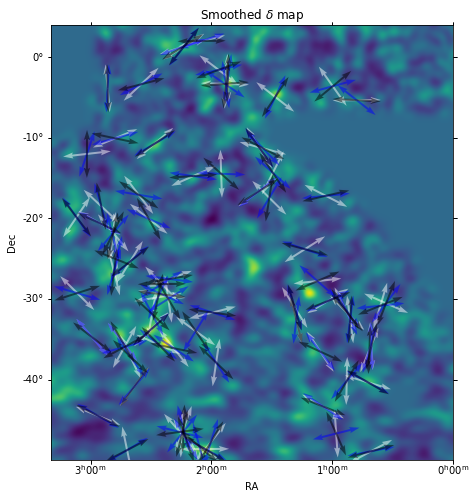

In [77]:
w = wcs.WCS(naxis=2)
height = float(od_smthmap_flat.shape[0])
length = float(od_smthmap_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]
# Make the figure
plt.figure(figsize=[12,8])
Xpix,Ypix = w.all_world2pix(ra_all[condition],dec_all[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_smthmap_flat)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")

# only plot some
ax1.quiver(Xpix, Ypix, U_arr_ideal, -V_arr_ideal, width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix, Ypix, -U_arr_ideal, V_arr_ideal, width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)

ax1.quiver(Xpix, Ypix, U_arr_nowgt, -V_arr_nowgt, width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix, Ypix, -U_arr_nowgt, V_arr_nowgt, width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)

ax1.quiver(Xpix, Ypix, U_arr_wgt, -V_arr_wgt, width=0.005, color = 'k', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix, Ypix, -U_arr_wgt, V_arr_wgt, width=0.005, color = 'k', scale = 3, scale_units = 'inches', alpha=.5)

plt.title(r"Smoothed $\delta$ map")
plt.xlabel("RA")
plt.ylabel("Dec")

In [88]:
dlist = [[1432,1632],[1532,1732],[1632,1832],[1732,1932], [1832,2032]]


# average differences
ideal_angles      = []
unweighted_angles = []
weighted_angles   = []
ra_all  = []
dec_all = []
for dbin in dlist:
    binmin, binmax = dbin[0], dbin[1]
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_ideal_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    ideal_angles.extend(angle)
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_unweighted_photoz_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    unweighted_angles.extend(angle)
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_weighted_photoz_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    weighted_angles.extend(angle)
    ra_all.extend(ra)
    dec_all.extend(dec)
ideal_angles = np.asarray(ideal_angles)
unweighted_angles =  np.asarray(unweighted_angles)
weighted_angles   = np.asarray(weighted_angles)
ra_all  = np.asarray(ra_all)
dec_all = np.asarray(dec_all)

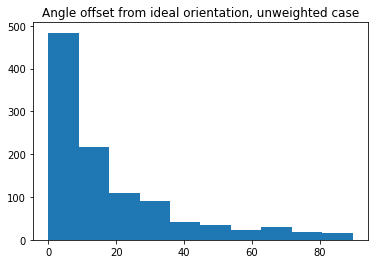

Text(0.5, 1.0, 'Angle offset from ideal orientation, weighted case')

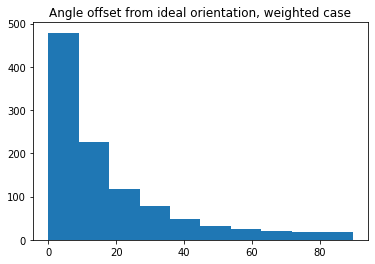

In [89]:
# compare
unwgt = calc_offsets(unweighted_angles, ideal_angles)
wgt   = calc_offsets(weighted_angles, ideal_angles)
plt.hist(unwgt.value)
plt.title("Angle offset from ideal orientation, unweighted case")
plt.show()
plt.hist(wgt.value)
plt.title("Angle offset from ideal orientation, weighted case")

In [90]:
np.average(unwgt)

<Quantity 18.38622534 deg>

In [91]:
np.average(wgt)

<Quantity 18.18825589 deg>

In [99]:
# 40 arcmin at 1532 Mpc is:
(cosmo.kpc_comoving_per_arcmin(z_at_value(cosmo.comoving_distance, 1532*u.Mpc))*40*u.arcmin).to(u.Mpc)

<Quantity 17.82562941 Mpc>

In [100]:
# 40 arcmin at 1932 Mpc is:
(cosmo.kpc_comoving_per_arcmin(z_at_value(cosmo.comoving_distance, 1932*u.Mpc))*40*u.arcmin).to(u.Mpc)

<Quantity 22.47984092 Mpc>

In [101]:
z_at_value(cosmo.comoving_distance, 1732*u.Mpc)-z_at_value(cosmo.comoving_distance, 1532*u.Mpc)

<Quantity 0.05637452 redshift>

# Maglim tests

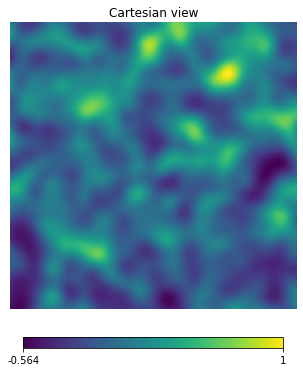

In [21]:
path = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/true_z/"
min_dist = 1432
max_dist = 1632
for f in os.listdir(path):
    
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
        hp.cartview(smthmap, lonra=[0,20], latra=[-10,10], max=1)


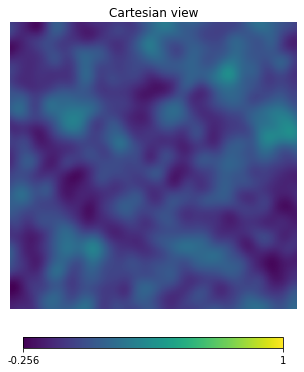

In [20]:
path = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_weighted/"
min_dist = 1432
max_dist = 1632
for f in os.listdir(path):
    
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
        hp.cartview(smthmap, lonra=[0,20], latra=[-10,10], max=1)


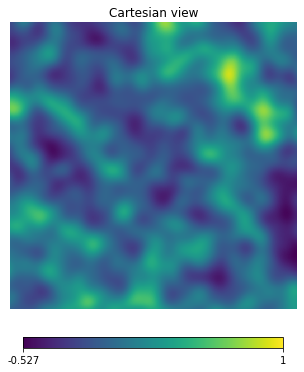

<Figure size 432x288 with 0 Axes>

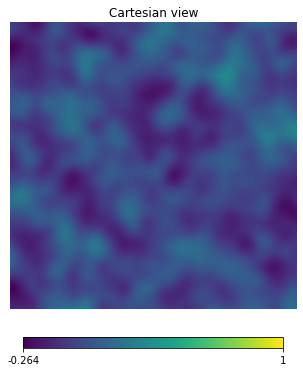

<Figure size 432x288 with 0 Axes>

In [23]:
path = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/true_z/"
min_dist = 1632
max_dist = 1832
for f in os.listdir(path):
    
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
        hp.cartview(smthmap, lonra=[0,20], latra=[-10,10], max=1)
        plt.show()
        plt.clf()
path = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_weighted/"

for f in os.listdir(path):
    
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
        hp.cartview(smthmap, lonra=[0,20], latra=[-10,10], max=1)
        plt.show()
        plt.clf()

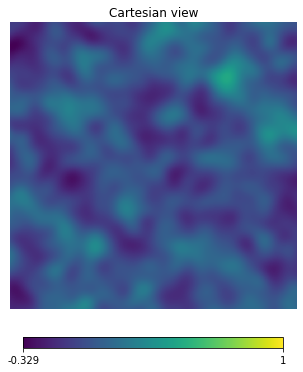

<Figure size 432x288 with 0 Axes>

In [24]:
path = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_unweighted/"

for f in os.listdir(path):
    
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
        hp.cartview(smthmap, lonra=[0,20], latra=[-10,10], max=1)
        plt.show()
        plt.clf()

# Ideal Version

In [18]:
#mode = 'ideal'
# mode = 'unweighted_photoz'
mode = 'weighted_photoz'
pkspath = "/mnt/scratch-lustre/mlokken/pkpatch/testing_photozs/"
if mode=='ideal':
    mapspath = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/true_z/"
elif mode=='unweighted_photoz':
    mapspath = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_unweighted/"
elif mode=='weighted_photoz':
    mapspath = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_weighted/"

In [16]:
dlist = [[1232,1432],[1332,1532],[1432,1632],[1532,1732],[1632,1832]]
lonmin=0
lonmax=40
latmin=0
latmax=20
for dbin in dlist:
    binmin, binmax = dbin[0], dbin[1]
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_{:s}_distMpc_{:d}_{:d}.fits".format(mode, binmin, binmax))
    if mode=='ideal':
        odmap = hp.read_map(mapspath+"odmap_1e+12_1e+16_distMpc{:d}_{:d}.fits".format(binmin,binmax))
    elif mode=='unweighted_photoz':
        odmap = hp.read_map(mapspath+"odmap_mock_maglim_photoz_nowgt_distMpc{:d}_{:d}_0arcmin.fits".format(binmin,binmax))
    elif mode=='weighted_photoz':
        odmap = hp.read_map(mapspath+"odmap_mock_maglim_photoz_wgt_distMpc{:d}_{:d}_0arcmin.fits".format(binmin,binmax))
    print("smoothing map.")
    smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
    od_smthmap_flat = hp.cartview(smthmap, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)
    condition = (ra>lonmin) & (ra < lonmax) & (dec>latmin) & (dec<latmax)
    w = wcs.WCS(naxis=2)
    height = float(od_smthmap_flat.shape[0])
    length = float(od_smthmap_flat.shape[1])
    cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
    cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
    w.wcs.crpix = length/2., height/2.
    print(w.wcs.crpix)
    w.wcs.crval = [crvalX,crvalY]
    print(w.wcs.crval)
    w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
    print(w.wcs.cdelt)
    w.wcs.ctype = ["RA", "DEC"]
    # Make the figure
    plt.figure(figsize=[12,8])
    Xpix,Ypix = w.all_world2pix(ra[condition],dec[condition],0)
    nrows = 1
    ax1 = plt.subplot(nrows, 1, 1, projection=w)
    ax1.imshow(od_smthmap_flat)
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    cm = plt.get_cmap("coolwarm")
    U_arr, V_arr = get_vector_components(angle[condition])
    ax1.scatter(Xpix,Ypix,color='w')
    # only plot some
    rand = np.random.choice(np.arange(len(Xpix)), size=60, replace=False)
    ax1.quiver(Xpix[rand], Ypix[rand], U_arr[rand], -V_arr[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
    ax1.quiver(Xpix[rand], Ypix[rand], -U_arr[rand], V_arr[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
    plt.title(r"Smoothed $\delta$ map")
    plt.xlabel("RA")
    plt.ylabel("Dec")
    break

In [19]:
# average differences
ideal_angles      = []
unweighted_angles = []
weighted_angles   = []
ra_all  = []
dec_all = []
for dbin in dlist:
    binmin, binmax = dbin[0], dbin[1]
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_ideal_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    ideal_angles.extend(angle)
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_unweighted_photoz_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    unweighted_angles.extend(angle)
    angle, ra, dec = cpp.peakinfo_radec(pkspath + "pksfile_weighted_photoz_distMpc_{:d}_{:d}.fits".format(binmin, binmax))
    weighted_angles.extend(angle)
    ra_all.extend(ra)
    dec_all.extend(dec)
ideal_angles = np.asarray(ideal_angles)
unweighted_angles =  np.asarray(unweighted_angles)
weighted_angles   = np.asarray(weighted_angles)
ra_all  = np.asarray(ra_all)
dec_all = np.asarray(dec_all)

In [52]:
condition = (ra_all>lonmin) & (ra_all < lonmax) & (dec_all>latmin) & (dec_all<latmax)
len(ideal_angles), len(unweighted_angles), len(weighted_angles)
U_arr_ideal, V_arr_ideal = get_vector_components(ideal_angles[condition])
U_arr_nowgt, V_arr_nowgt = get_vector_components(unweighted_angles[condition])
U_arr_wgt, V_arr_wgt = get_vector_components(weighted_angles[condition])

[400. 200.]
[20. 10.]
[-0.05  0.05]


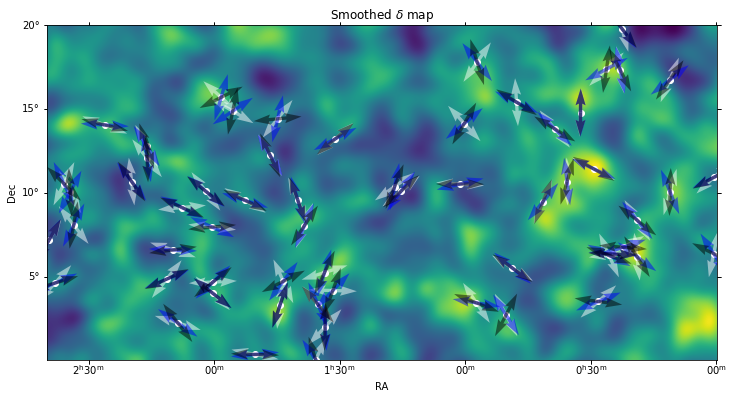

In [55]:
w = wcs.WCS(naxis=2)
height = float(od_smthmap_flat.shape[0])
length = float(od_smthmap_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]
# Make the figure
plt.figure(figsize=[12,8])
Xpix,Ypix = w.all_world2pix(ra_all[condition],dec_all[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_smthmap_flat)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")

# only plot some
rand = np.random.choice(np.arange(len(Xpix)), size=60, replace=False)
ax1.scatter(Xpix[rand],Ypix[rand],color='w')
ax1.quiver(Xpix[rand], Ypix[rand], U_arr_ideal[rand], -V_arr_ideal[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_ideal[rand], V_arr_ideal[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)

ax1.quiver(Xpix[rand], Ypix[rand], U_arr_nowgt[rand], -V_arr_nowgt[rand], width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_nowgt[rand], V_arr_nowgt[rand], width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)

ax1.quiver(Xpix[rand], Ypix[rand], U_arr_wgt[rand], -V_arr_wgt[rand], width=0.005, color = 'k', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_wgt[rand], V_arr_wgt[rand], width=0.005, color = 'k', scale = 3, scale_units = 'inches', alpha=.5)

plt.title(r"Smoothed $\delta$ map")
plt.xlabel("RA")
plt.ylabel("Dec")

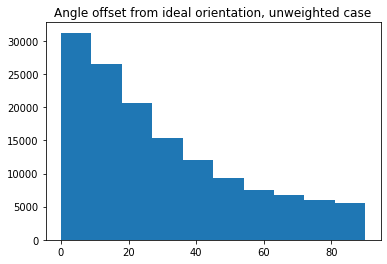

Text(0.5, 1.0, 'Angle offset from ideal orientation, weighted case')

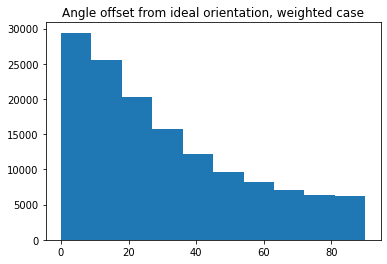

In [134]:
# compare
unwgt = calc_offsets(unweighted_angles, ideal_angles)
wgt   = calc_offsets(weighted_angles, ideal_angles)
plt.hist(unwgt.value)
plt.title("Angle offset from ideal orientation, unweighted case")
plt.show()
plt.hist(wgt.value)
plt.title("Angle offset from ideal orientation, weighted case")

In [59]:
np.average(unwgt), np.average(wgt)

(<Quantity 29.81942463 deg>, <Quantity 31.019826 deg>)

In [69]:
# get the comparison from the full projected bin
angle_proj, ra_proj, dec_proj = cpp.peakinfo_radec("/mnt/scratch-lustre/mlokken/pkpatch/testing_photozs/pksfile_unweighted_photoz_combined_deltaz_pt15_0.31_0.45.fits")

In [117]:
sorted_proj = np.argsort(ra_proj)
angle_proj_sorted, ra_proj_sorted, dec_proj_sorted = angle_proj[sorted_proj], ra_proj[sorted_proj], dec_proj[sorted_proj]
sorted_proj2 = np.argsort(dec_proj_sorted)
angle_proj_sorted2, ra_proj_sorted2, dec_proj_sorted2 = angle_proj_sorted[sorted_proj2], ra_proj_sorted[sorted_proj2], dec_proj_sorted[sorted_proj2]

In [118]:
sorted_all = np.argsort(ra_all)
ideal_angles_sorted, ra_all_sorted, dec_all_sorted = ideal_angles[sorted_all], ra_all[sorted_all], dec_all[sorted_all]
sorted_all2 = np.argsort(dec_all_sorted)
ideal_angles_sorted2, ra_all_sorted2, dec_all_sorted2 = ideal_angles_sorted[sorted_all2], ra_all_sorted[sorted_all2], dec_all_sorted[sorted_all2]

In [122]:
i=500

In [123]:
ra_proj_sorted2[i], dec_proj_sorted2[i]

(202.02438711976933, -82.97146714544641)

In [124]:
ra_all_sorted2[i], dec_all_sorted2[i]

(202.02438711976933, -82.97146714544641)

In [125]:
proj_angle_offsets = calc_offsets(angle_proj_sorted2, ideal_angles_sorted2)

In [126]:
np.average(proj_angle_offsets)

<Quantity 43.17052536 deg>

In [127]:
condition = (ra_all_sorted2>lonmin) & (ra_all_sorted2 < lonmax) & (dec_all_sorted2>latmin) & (dec_all_sorted2<latmax)
U_arr_ideal, V_arr_ideal = get_vector_components(ideal_angles_sorted2[condition])
U_arr_proj, V_arr_proj = get_vector_components(angle_proj_sorted2[condition])

[400. 200.]
[20. 10.]
[-0.05  0.05]


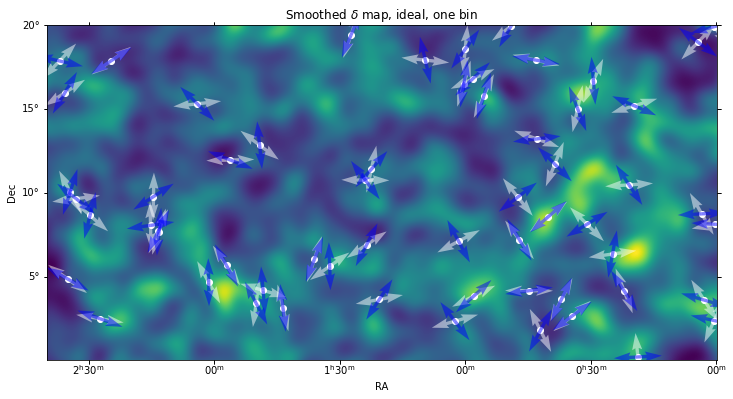

<Figure size 432x288 with 0 Axes>

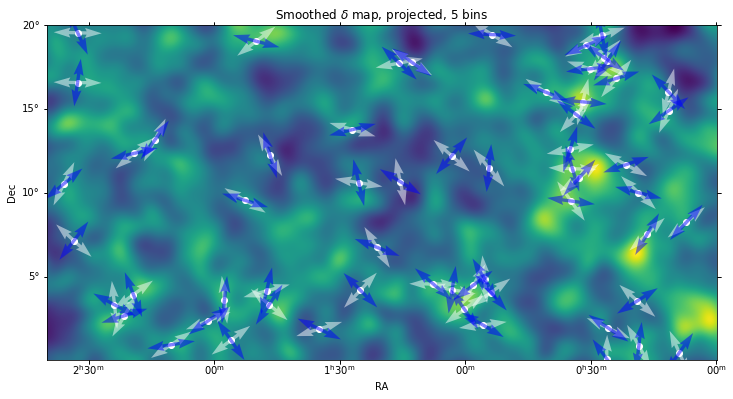

In [128]:
odmap_ideal = hp.read_map("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/true_z/"+"odmap_1e+12_1e+16_distMpc{:d}_{:d}.fits".format(1432,1632))
odmap_proj  = hp.read_map("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_unweighted/odmap_deltaz_pt15_0.31_0.45.fits")
# smthmap_ideal         = hp.smoothing(odmap_ideal, sigma=np.deg2rad(.5))
# od_smthmap_flat_ideal = hp.cartview(smthmap_ideal, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

# smthmap_proj         = hp.smoothing(odmap_proj, sigma=np.deg2rad(.5))
# od_smthmap_flat_proj = hp.cartview(smthmap_proj, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

w = wcs.WCS(naxis=2)
height = float(od_smthmap_flat.shape[0])
length = float(od_smthmap_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

# Make the figure
plt.figure(figsize=[12,8])
Xpix,Ypix = w.all_world2pix(ra_all_sorted2[condition],dec_all_sorted2[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_smthmap_flat_ideal)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")

# only plot some
rand = np.random.choice(np.arange(len(Xpix)), size=60, replace=False)
ax1.scatter(Xpix[rand],Ypix[rand],color='w')
ax1.quiver(Xpix[rand], Ypix[rand], U_arr_ideal[rand], -V_arr_ideal[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_ideal[rand], V_arr_ideal[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], U_arr_proj[rand], -V_arr_proj[rand], width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_proj[rand], V_arr_proj[rand], width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)
plt.title(r"Smoothed $\delta$ map, ideal, one bin")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()
plt.clf()
# Make the figure
plt.figure(figsize=[12,8])
Xpix,Ypix = w.all_world2pix(ra_all_sorted2[condition],dec_all_sorted2[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_smthmap_flat_proj)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")

# only plot some
rand = np.random.choice(np.arange(len(Xpix)), size=60, replace=False)
ax1.scatter(Xpix[rand],Ypix[rand],color='w')
ax1.quiver(Xpix[rand], Ypix[rand], U_arr_ideal[rand], -V_arr_ideal[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_ideal[rand], V_arr_ideal[rand], width=0.005, color = 'w', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], U_arr_proj[rand], -V_arr_proj[rand], width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)
ax1.quiver(Xpix[rand], Ypix[rand], -U_arr_proj[rand], V_arr_proj[rand], width=0.005, color = 'b', scale = 3, scale_units = 'inches', alpha=.5)
plt.title(r"Smoothed $\delta$ map, projected, 5 bins")
plt.xlabel("RA")
plt.ylabel("Dec")

(array([16192., 15551., 14750., 14473., 13788., 13498., 13306., 13075.,
        13153., 13117.]),
 array([5.30933522e-04, 9.00047538e+00, 1.80004198e+01, 2.70003643e+01,
        3.60003087e+01, 4.50002532e+01, 5.40001976e+01, 6.30001421e+01,
        7.20000865e+01, 8.10000310e+01, 8.99999754e+01]),
 <BarContainer object of 10 artists>)

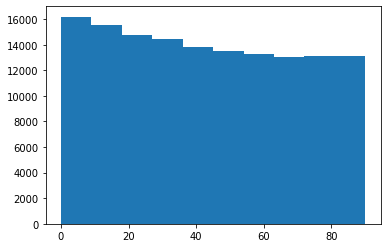

In [131]:
plt.hist(calc_offsets(angle_proj_sorted2, ideal_angles_sorted2).value)

In [132]:
# check that random sorting gives 90 deg offsets
np.average(calc_offsets(angle_proj_sorted2, ideal_angles_sorted2))

<Quantity 43.17052536 deg>

In [81]:
df_proj   = pd.DataFrame({"angle": angle_proj, "ra": ra_proj, "dec": dec_proj})
df_allbin = pd.DataFrame({"angle": ideal_angles, "ra": ra_all, "dec": dec_all})

In [70]:
proj   = calc_offsets(angle_proj, ideal_angles)

In [71]:
np.average(proj)

<Quantity 45.06213092 deg>

In [61]:
# make the full
pzcat = np.load("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/mock_maglim_photoz.npy")
ra, dec, gal_photoz = pzcat[:,0], pzcat[:,1], pzcat[:,2]

In [62]:
theta,phi   = csf.DeclRatoThetaPhi(dec,ra)
thetaphi    = np.zeros((len(theta),2))
thetaphi[:,0] = theta
thetaphi[:,1] = phi

In [63]:
lrgbin_lowz = z_at_value(cosmo.comoving_distance, (dlist[0][0]+50)*u.Mpc)
lrgbin_hiz  = z_at_value(cosmo.comoving_distance, (dlist[-1][1]-50)*u.Mpc)
print(lrgbin_lowz, lrgbin_hiz)
lrgbin_save = (lrgbin_lowz<gal_photoz)&(gal_photoz<lrgbin_hiz)

0.31331964205528123 redshift 0.45203097791850627 redshift


In [65]:
thetaphi_save =thetaphi[lrgbin_save]
odmap = csf.get_od_map(4096, thetaphi_save[:,0], thetaphi_save[:,1], None, 0)


Mean of number density map:  0.11932162443796794
Mean of overdensity map:  1.9964546350930852e-13


In [68]:
hp.write_map("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/photoz_unweighted/odmap_deltaz_pt15_0.31_0.45.fits", odmap)

setting the output map dtype to [dtype('float64')]


In [14]:
lonmin=-10
lonmax=10
latmin=-10
latmax=10

[400. 800.]
[0. 0.]
[-0.025   0.0125]


SyntaxError: 'break' outside loop (55777630.py, line 29)

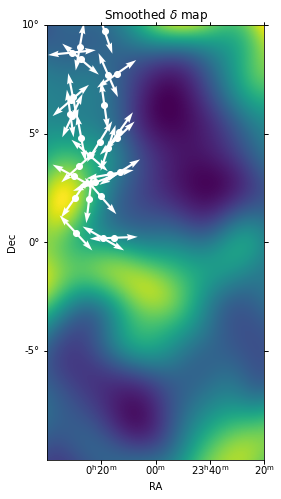

In [15]:
w = wcs.WCS(naxis=2)
height = float(od_smthmap_flat.shape[0])
length = float(od_smthmap_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]
# Make the figure
plt.figure(figsize=[8,8])
Xpix,Ypix = w.all_world2pix(ra[condition],dec[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_smthmap_flat)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")
U_arr, V_arr = get_vector_components(angle[condition])
ax1.scatter(Xpix,Ypix,color='w')
ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.01, color = 'w', scale = 3, scale_units = 'inches')
ax1.quiver(Xpix,Ypix, -U_arr, V_arr, width=0.01, color = 'w', scale = 3, scale_units = 'inches')
plt.title(r"Smoothed $\delta$ map")
plt.xlabel("RA")
plt.ylabel("Dec")
break

In [ ]:
# plots to check
lonmin=3
lonmax=8
latmin=0
latmax=10
path = "/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/mock_maglim/true_z/"
min_dist = 1232
max_dist = 1432

for f in os.listdir(path):
    if str(min_dist) in f and str(max_dist) in f:
        odmap = hp.read_map(path+f)
        smthmap = hp.smoothing(odmap, sigma=np.deg2rad(.5))
od_map_flat = hp.cartview(odmap, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)
od_smthmap_flat = hp.cartview(smthmap, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)
condition = (ra>lonmin) & (ra < lonmax) & (dec>latmin) & (dec<latmax)
w = wcs.WCS(naxis=2)
height = float(od_map_flat.shape[0])
length = float(od_map_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

# Make the figure
plt.figure(figsize=[8,8])
Xpix,Ypix = w.all_world2pix(ra[condition],dec[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_map_flat, vmax=5, cmap='PRGn')
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")
U_arr, V_arr = get_vector_components(angle[condition])
ax1.scatter(Xpix,Ypix,color='w')
ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.01, color = 'w', scale = 3, scale_units = 'inches')
ax1.quiver(Xpix,Ypix, -U_arr, V_arr, width=0.01, color = 'w', scale = 3, scale_units = 'inches')
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title(r"Unsmoothed $\delta$ map")
plt.show()
plt.clf()

# Make the figure
plt.figure(figsize=[8,8])
Xpix,Ypix = w.all_world2pix(ra[condition],dec[condition],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_smthmap_flat)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")
U_arr, V_arr = get_vector_components(angle[condition])
ax1.scatter(Xpix,Ypix,color='w')
ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.01, color = 'w', scale = 3, scale_units = 'inches')
ax1.quiver(Xpix,Ypix, -U_arr, V_arr, width=0.01, color = 'w', scale = 3, scale_units = 'inches')
plt.title(r"Smoothed $\delta$ map")
plt.xlabel("RA")
plt.ylabel("Dec")


In [3]:
min_dist = 2432
max_dist = 2632

In [4]:
halos = np.load("/mnt/scratch-lustre/mlokken/pkpatch/halos_fullsky_M_gt_1pt5E12.npy")

In [5]:
M = halos[:,0]
cls  = M>10**14
x_cls,y_cls,z_cls  = halos[:,1][cls], halos[:,2][cls], halos[:,3][cls]
chi_cls = np.sqrt(x_cls**2+y_cls**2+z_cls**2)
rshifts_cl = cosmology.zofchi(chi_cls)

x_gals,y_gals,z_gals  = halos[:,1], halos[:,2], halos[:,3]
chi_gals = np.sqrt(x_gals**2+y_gals**2+z_gals**2)
rshifts_gal = cosmology.zofchi(chi_gals)

# Redmagic

In [6]:
# messing up zs to photo-zs
z = z_at_value(cosmo.comoving_distance, (min_dist+max_dist)/2.*u.Mpc)
sigma_z_gal = .013*(1+z)
# sigma_z_gal = 0*(1+z)
print("galaxy errors: ", sigma_z_gal)

sigma_z_cl = .01*(1+z)
# sigma_z_cl = 0*(1+z)
print("cluster errors: ", sigma_z_cl)

gal_photoz = np.random.normal(rshifts_gal, sigma_z_gal)
cl_photoz  = np.random.normal(rshifts_cl, sigma_z_cl)


galaxy errors:  0.02189719426797676
cluster errors:  0.016843995590751355


(array([8.2200e+02, 7.7190e+03, 2.0373e+04, 3.5593e+04, 5.1993e+04,
        6.4194e+04, 7.4651e+04, 8.1109e+04, 8.5052e+04, 8.4801e+04,
        8.2402e+04, 7.7499e+04, 7.1786e+04, 6.5209e+04, 5.7415e+04,
        5.0259e+04, 4.3443e+04, 3.6428e+04, 3.0870e+04, 2.5283e+04,
        2.0701e+04, 1.6732e+04, 1.3319e+04, 1.0564e+04, 8.2790e+03,
        6.5590e+03, 4.8680e+03, 3.7190e+03, 2.9220e+03, 2.1060e+03,
        1.5900e+03, 1.1860e+03, 8.7200e+02, 5.9100e+02, 4.4300e+02,
        3.0900e+02, 2.2600e+02, 1.6600e+02, 1.1600e+02, 8.3000e+01,
        4.2000e+01, 3.8000e+01, 2.8000e+01, 2.1000e+01, 8.0000e+00,
        6.0000e+00, 5.0000e+00, 5.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-0.01974265,  0.04812055,  0.11598374,  0.18384694,  0.25171013,
         0.31957333,  0.38743652,  0.45529972,  0.52316291,  0.59102611,
         0.6588893 ,  0.7267525 ,  0.79461569,  0.86247889,  0.93034208,
         0.99820528,  1.06606848,  1.13393167,  1.20179487,  1.26965806,
         1.33752126,  1.40

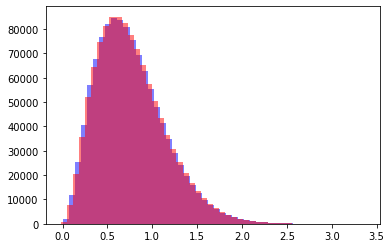

In [7]:
plt.hist(rshifts_cl,color='b', alpha=.5, bins=50)
plt.hist(cl_photoz, color='r', alpha=.5, bins=50)

In [8]:
# now slice them
inslice_cl = (cl_photoz > z_at_value(cosmo.comoving_distance, min_dist*u.Mpc)) & (cl_photoz < z_at_value(cosmo.comoving_distance, max_dist*u.Mpc))
inslice_gal = (gal_photoz > z_at_value(cosmo.comoving_distance, min_dist*u.Mpc)) & (gal_photoz < z_at_value(cosmo.comoving_distance, max_dist*u.Mpc))

ra_cl,dec_cl = halos[:,4][cls][inslice_cl], halos[:,5][cls][inslice_cl]
ra_gal,dec_gal = halos[:,4][inslice_gal], halos[:,5][inslice_gal]

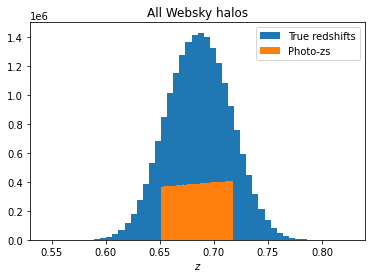

Text(0.5, 1.0, 'Websky halos, $M>10^{14} \\mathrm{M}_{\\odot}$')

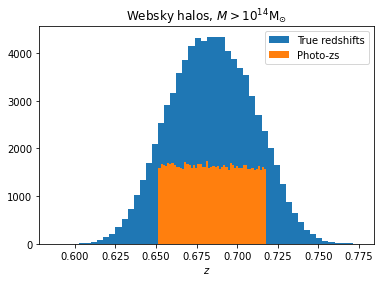

In [9]:
plt.hist(rshifts_gal[inslice_gal], bins=50, label='True redshifts')
plt.hist(gal_photoz[inslice_gal], bins=50, label='Photo-zs')
plt.xlabel("$z$")
plt.title("All Websky halos")
plt.legend()
plt.show()
plt.clf()

plt.hist(rshifts_cl[inslice_cl], bins=50, label='True redshifts')
plt.hist(cl_photoz[inslice_cl], bins=50, label='Photo-zs')
plt.xlabel("$z$")
plt.legend()
plt.title("Websky halos, $M>10^{14} \mathrm{M}_{\odot}$")

In [10]:
# what percentage of galaxies are outside the bin?
cond = np.logical_or((rshifts_gal[inslice_gal]<z_at_value(cosmo.comoving_distance, min_dist*u.Mpc)),(rshifts_gal[inslice_gal]>z_at_value(cosmo.comoving_distance, max_dist*u.Mpc)))
print("{:0.1f}% of galaxies are truly outside the photo-z bin".format(len(rshifts_gal[inslice_gal][cond])/len(rshifts_gal[inslice_gal])*100))
# what percentage of clusters?
cond = np.logical_or((rshifts_cl[inslice_cl]<z_at_value(cosmo.comoving_distance, min_dist*u.Mpc)),(rshifts_cl[inslice_cl]>z_at_value(cosmo.comoving_distance, max_dist*u.Mpc)))
print("{:0.1f}% of clusters are truly outside the photo-z bin".format(len(rshifts_cl[inslice_cl][cond])/len(rshifts_cl[inslice_cl])*100))

26.2% of galaxies are truly outside the photo-z bin
20.3% of clusters are truly outside the photo-z bin


# MagLim

In [11]:
# worst bin: sigma_z= .07
# messing up zs to photo-zs
z = z_at_value(cosmo.comoving_distance, (min_dist+max_dist)/2.*u.Mpc)
sigma_z_gal = .07
# sigma_z_gal = 0*(1+z)
print("galaxy errors: ", sigma_z_gal)

gal_photoz = np.random.normal(rshifts_gal, sigma_z_gal)


galaxy errors:  0.07


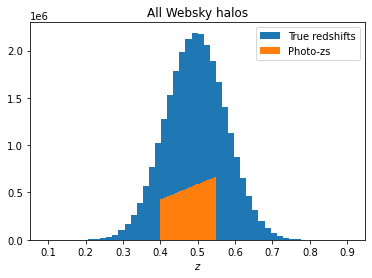

<Figure size 432x288 with 0 Axes>

In [14]:
# now slice them
inslice_gal = (gal_photoz > .4) & (gal_photoz < .55)
plt.hist(rshifts_gal[inslice_gal], bins=50, label='True redshifts')
plt.hist(gal_photoz[inslice_gal], bins=50, label='Photo-zs')
plt.xlabel("$z$")
plt.title("All Websky halos")
plt.legend()
plt.show()
plt.clf()

In [17]:
# what percentage of galaxies are outside the bin?
cond = np.logical_or((rshifts_gal[inslice_gal]<.4),(rshifts_gal[inslice_gal]>.55))
print("{:0.1f}% of galaxies are truly outside the photo-z bin".format(len(rshifts_gal[inslice_gal][cond])/len(rshifts_gal[inslice_gal])*100))


36.7% of galaxies are truly outside the photo-z bin


In [18]:
100-36.7

63.3

In [13]:
smoothing = (cosmo.arcsec_per_kpc_comoving(z).to(u.arcsec/u.megaparsec)*13.9*u.Mpc)
smoothing.to(u.arcmin)


<Quantity 42.2126154 arcmin>

In [14]:
theta_cl, phi_cl  = csf.DeclRatoThetaPhi(dec_cl, ra_cl)
theta_gal, phi_gal  = csf.DeclRatoThetaPhi(dec_gal, ra_gal)


In [15]:
box = (ra_cl>0)&(ra_cl<40)&(dec_cl<5)&(dec_cl>-10)
thetaphi = np.zeros((len(theta_cl),2))
thetaphi[:,0] = theta_cl
thetaphi[:,1] = phi_cl

np.savetxt("/mnt/scratch-lustre/mlokken/pkpatch/testing_photozs/thetaphi_websky_cls_photozs_{:d}_{:d}.txt".format(min_dist,max_dist), thetaphi)

od_map = csf.get_od_map(4096, theta_gal, phi_gal, mass=M[inslice_gal], mask=None, smth=0)
hp.write_map("/mnt/scratch-lustre/mlokken/pkpatch/testing_photozs/odmap_websky_gals_photozs_{:d}_{:d}.fits".format(min_dist,max_dist), od_map, overwrite=True)


Mean of number density map:  0.17772659433845447
Mean of overdensity map:  7.671886118557041e-14


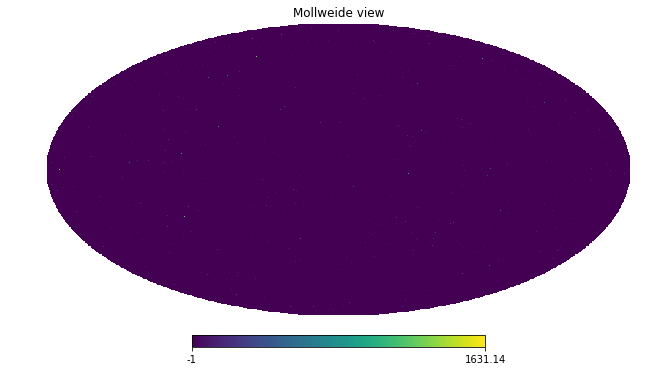

In [42]:
# od_map = hp.read_map("/home/mlokken/oriented_stacking/sims_only_code/odmap_websky_gals_photozs_1632_1832.fits")
hp.mollview(od_map)


Sigma is 11.716100 arcmin (0.003408 rad) 
-> fwhm is 27.589307 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


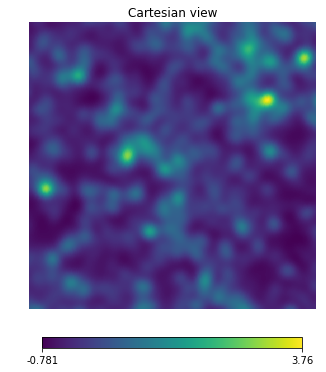

In [43]:
odmap_smooth = hp.smoothing(od_map, fwhm=np.deg2rad(smoothing.value/3600.))
lonmin=0
lonmax=10
latmin=-5
latmax=5
odmap_flat = hp.cartview(odmap_smooth, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

In [48]:
w = wcs.WCS(naxis=2)

height = float(odmap_flat.shape[0])
length = float(odmap_flat.shape[1])
w = wcs.WCS(naxis=2)
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.

w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

small_box = (ra_cl>0)&(ra_cl<10)&(dec_cl<5)&(dec_cl>-5)

Xpix,Ypix = w.all_world2pix(ra_cl[small_box],dec_cl[small_box],0)


NameError: name 'odmap_flat' is not defined

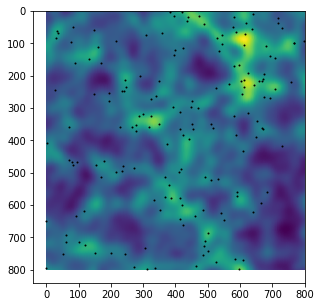

In [186]:
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=[7,5])

ax.imshow(odmap_flat[::-1])
ax.scatter(Xpix, Ypix, s=1,edgecolor='black', facecolor='black')


In [164]:
peakfile = fits.open("websky_Mgt1e+14_photozs_1632_1832_pks.fits")
peakinfo = peakfile[0].data
rot_angle = peakinfo[:,3]
theta,phi = peakinfo[:,1], peakinfo[:,2]
dec = []
ra  = []
for i in range(len(theta)):
    dec.append(csf.ThetaPhitoRaDec(theta[i],phi[i])[1])
    ra.append(csf.ThetaPhitoRaDec(theta[i],phi[i])[0])

ra = np.asarray(ra)
dec = np.asarray(dec)
in_region = (ra>lonmin) & (ra < lonmax) & (dec < latmax) & (dec > latmin)
ra = ra[in_region]
dec = dec[in_region]
rot_angle = rot_angle[in_region]
peakfile.close()

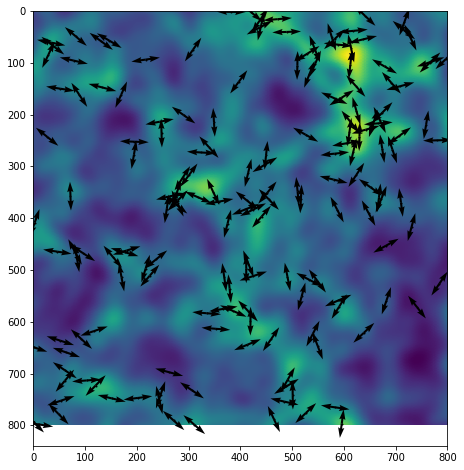

In [165]:
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=[10,8])

ax.imshow(odmap_flat[::-1])
ax.scatter(Xpix, Ypix, s=1,edgecolor='black', facecolor='black')
U, V = get_vector_components(rot_angle)
ax.quiver(Xpix, Ypix, -U, V, width=0.005, color = 'k', scale_units = 'inches', scale = 5)
ax.quiver(Xpix, Ypix, U, -V, width=0.005, color = 'k', scale_units = 'inches', scale = 5)

Sigma is 11.936638 arcmin (0.003472 rad) 
-> fwhm is 28.108635 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


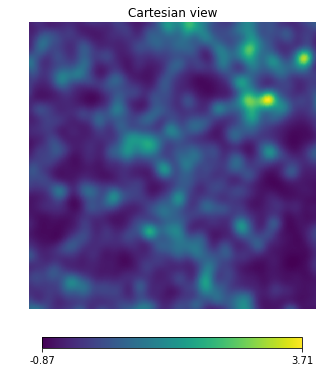

In [101]:
# od_map_ideal = hp.read_map("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/1pt5E12_to_1E15_msun/odmap_distMpc_1632_1832_0Mpc_0arcmin.fits")
od_map_ideal = hp.smoothing(od_map_ideal, fwhm=np.deg2rad(smoothing.value/3600))
odmap_id_flat = hp.cartview(od_map_ideal, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

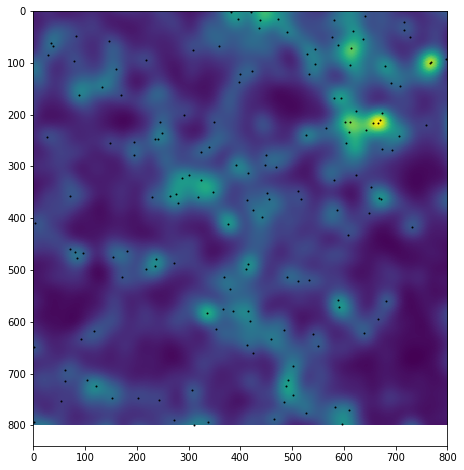

In [166]:
inslice_cl_ideal = (rshifts_cl> z_at_value(cosmo.comoving_distance, 1632*u.Mpc)) & (rshifts_cl < z_at_value(cosmo.comoving_distance, 1832*u.Mpc))
ra_ideal, dec_ideal = halos[:,4][cls][inslice_cl_ideal], halos[:,5][cls][inslice_cl_ideal]
box = (ra_ideal>0) & (ra_ideal<10) & (dec_ideal<5) & (dec_ideal>-5)
Xpix_id,Ypix_id = w.all_world2pix(ra_ideal,dec_ideal,0)
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=[10,8])
ax.imshow(odmap_id_flat[::-1])
ax.scatter(Xpix_id[box], Ypix_id[box], s=1,edgecolor='black', facecolor='black')


In [20]:
min_dist = 1632
max_dist = 1832

Photo-z uncertainties reduce the signal by 8.81%


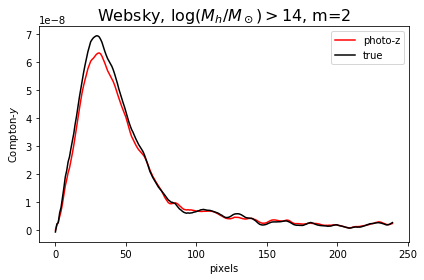

In [21]:
# import perfect stack
m=2
fig, ax = plt.subplots(nrows=1,ncols=1)
websky_prof = pickle.load(open("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt1e+14_{:d}_{:d}Mpc_13pt9Mpc_smth_48reg_m0to5_profiles.pkl".format(min_dist, max_dist), "rb"))

binned_r, y_mean_binned, covmat_binned, cormat_binned, errors_binned, npks_tot = cpp.getprofs(websky_prof, 48, m)[5:]
r_ideal, y_ideal=cpp.getprofs(websky_prof, 48, m)[:2]

photoz_y = np.loadtxt("/mnt/scratch-lustre/mlokken/pkpatch/testing_photozs/websky_Mgt1e+14_photozs_{:d}_{:d}_stack_HankelTransform_m{:d}.txt".format(min_dist, max_dist, m))
plt.plot(r_ideal, photoz_y[:,1], label='photo-z', color='red')
plt.plot(r_ideal, y_ideal, label='true', color='black')
plt.legend()


ax.set_xlabel("pixels")
ax.set_ylabel("Compton-$y$")
ax.set_title(r"Websky, $\log(M_h/M_\odot)>14$, m={:d}".format(m), fontsize=16)
plt.tight_layout()

print("Photo-z uncertainties reduce the signal by {:.2f}%".format((np.amax(y_ideal)-np.amax(photoz_y[:,1]))/np.amax(y_ideal)*100))